## 사용 데이터셋
18,846 개의 뉴스 문서 / 20개의 카테고리로 분류

In [ ]:
from sklearn.datasets import fetch_20newsgroups

# 훈련 데이터와 테스트 데이터를 모두 가져옴
# news_data는 data, target으로 구성됨
news_data = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'))

In [ ]:
# data 확인
news_data.data[:1]

["\n\nI am sure some bashers of Pens fans are pretty confused about the lack\nof any kind of posts about the recent Pens massacre of the Devils. Actually,\nI am  bit puzzled too and a bit relieved. However, I am going to put an end\nto non-PIttsburghers' relief with a bit of praise for the Pens. Man, they\nare killing those Devils worse than I thought. Jagr just showed you why\nhe is much better than his regular season stats. He is also a lot\nfo fun to watch in the playoffs. Bowman should let JAgr have a lot of\nfun in the next couple of games since the Pens are going to beat the pulp out of Jersey anyway. I was very disappointed not to see the Islanders lose the final\nregular season game.          PENS RULE!!!\n\n"]

In [ ]:
# 컬럼 확인
print(news_data.keys())

dict_keys(['data', 'filenames', 'target_names', 'target', 'DESCR'])


In [ ]:
# 컬럼별 데이터 확인
print("data :",news_data.data[0])
print("filenames :", news_data.filenames[0])
print("target_name :", news_data.target_names[0])
print("target :",news_data.target[0])
print("DESCR :", news_data.DESCR[0])

data : 

I am sure some bashers of Pens fans are pretty confused about the lack
of any kind of posts about the recent Pens massacre of the Devils. Actually,
I am  bit puzzled too and a bit relieved. However, I am going to put an end
to non-PIttsburghers' relief with a bit of praise for the Pens. Man, they
are killing those Devils worse than I thought. Jagr just showed you why
he is much better than his regular season stats. He is also a lot
fo fun to watch in the playoffs. Bowman should let JAgr have a lot of
fun in the next couple of games since the Pens are going to beat the pulp out of Jersey anyway. I was very disappointed not to see the Islanders lose the final
regular season game.          PENS RULE!!!


filenames : /root/scikit_learn_data/20news_home/20news-bydate-test/rec.sport.hockey/54367
target_name : alt.atheism
target : 10
DESCR : .


In [ ]:
## unique 한 카테고리 분류 확인

import numpy as np

#num_unique_categories = len(np.unique(news_data.target))
num_unique_categories = len(set(news_data.target))
num_data = len(news_data.data)
print(f"데이터 개수: {num_data}")
print(f"고유한 카테고리 개수: {num_unique_categories}")
print("카테고리 이름 목록:")
print(news_data.target)

데이터 개수: 18846
고유한 카테고리 개수: 20
카테고리 이름 목록:
[10  3 17 ...  3  1  7]


## DataFrame 으로 변환

In [ ]:
import pandas as pd

df = pd.DataFrame({
    'text': news_data.data,
    'label': news_data.target,
    'category': [news_data.target_names[i] for i in news_data.target]
})

## 중복된 데이터 처리

In [ ]:
df_dedup = df.drop_duplicates(subset='text', keep='first').reset_index(drop=True)
 # 본문이 같은 경우만 중복으로 간주 , 중복 중 첫 번째 것만 남기고 나머지 삭제, 중복 제거 후 다시 번호 부여
print(f"중복된 데이터 {18846 - len(df_dedup['text'])}개 삭제")

중복된 데이터 559개 삭제


## 데이터 전처리
- 앞 숫자 제거
- 줄임표 제거
- 슬래시 → 공백
- 하이픈 → 공백
- 알파벳/숫자/공백을 제외한 모든 특수문자 제거
- 줄바꿈 , 탭 , 캐리지리턴을 공백으로 치환
- 나머지 특수문자 제거
- spaCy 적용
- 데이터 훈련 세트와 테스트 세트로 분리(8:2)

## 형태소 분석기
- 영어 : spaCy , NLTK , Stanza , TextBlob
- spaCy 사용

## spaCy의 기능

- Tokenization (토큰화) / Part-of-Speech Tagging (품사 태깅) / Named Entity Recognition (NER) (개체명 인식) / Dependency Parsing (의존 구문 분석) / Lemmatization (표제어 추출) / Sentence Segmentation (문장 분리) / Text Classification (텍스트 분류)

In [ ]:
!pip install torch --upgrade

In [ ]:
!pip install gensim

In [ ]:
pip install -U spacy[cuda,transformers]

In [ ]:
!pip install tqdm

In [ ]:
!python -m spacy download en_core_web_trf

In [ ]:
import re
import spacy
import torch
import numpy as np
from tqdm import tqdm
import pandas as pd
from textblob import TextBlob  # 오타 보정용

tqdm.pandas()

# spaCy GPU 설정 및 모델 로딩
spacy.prefer_gpu()
nlp = spacy.load("en_core_web_trf")

# 1. 텍스트 정제 함수
def clean_text(text):
    text = re.sub(r'^\s*\d+[\)\.\-]\s*', '', text) # 맨 앞의 번호 패턴 제거 (예: "1)", "2. ", "3- " 등)
    text = text.replace('...', ' ') # 줄임표(...)를 공백으로 치환
    text = re.sub(r'/', ' ', text) # 슬래시(/)를 공백으로 치환
    text = re.sub(r'-', ' ', text) # 하이픈(-)을 공백으로 치환
    text = re.sub(r'[^\w\s]', '', text) # 알파벳/숫자/공백을 제외한 모든 특수문자 제거
    text = re.sub(r'[\n\t\r]', ' ', text) # 줄바꿈(\n), 탭(\t), 캐리지리턴(\r)을 공백으로 치환
    text = re.sub(r'\s+', ' ', text).strip()  # 연속된 공백을 하나로 줄이고, 양쪽 공백 제거
    return text

# 2. 오타 보정 함수 (선택)
def correct_spelling(text):
    corrected_words = []
    for word in text.split():
        if len(word) > 2:
            corrected = str(TextBlob(word).correct())
            corrected_words.append(corrected)
        else:
            corrected_words.append(word)
    return ' '.join(corrected_words)

# 3. 단어 필터링 함수 (노이즈 제거)
def is_valid_token(token):
    if len(token) < 3:
        return False
    if len(set(token)) == 1:  # aaa, xxx
        return False
    if re.search(r'(..)\1{2,}', token):  # axaxaxax, hahaha
        return False
    if re.search(r'[^a-zA-Z]', token):  # 기호 포함
        return False
    return True

# 4. spaCy lemmatization + 필터링 적용
def spacy_tokenize_to_string(text_list):
    results = []
    for doc in tqdm(nlp.pipe(text_list, batch_size=16), total=len(text_list)):
        tokens = [
            token.lemma_.lower()
            for token in doc
            if token.is_alpha and not token.is_stop and is_valid_token(token.lemma_.lower())
        ]
        results.append(' '.join(tokens))
    return results

SyntaxError: invalid syntax (ipython-input-67-1358438198.py, line 17)

- 속도 문제로 오타 보정을 하지 않고 나머지 를 적용 해서 전처리 및 토큰화

In [ ]:
# 1단계: 텍스트 정제
df_dedup['clean_text'] = df_dedup['text'].progress_apply(clean_text)

# 2단계: 오타 보정 → 느려서 주석처리
# df_dedup['clean_text'] = df_dedup['clean_text'].progress_apply(correct_spelling)

# 3단계: spaCy 적용 + 필터링
df_dedup['clean_text'] = spacy_tokenize_to_string(df_dedup['clean_text'].tolist())

# 4단계: 문자열을 token list로 변환
df_dedup['tokens'] = df_dedup['clean_text'].apply(lambda x: x.split())

100%|██████████| 18287/18287 [08:40<00:00, 35.14it/s]


In [ ]:
pd.set_option('display.max_colwidth', None)
df_dedup[['text','clean_text']][:5]

,text,clean_text
0,"\n\nI am sure some bashers of Pens fans are pretty confused about the lack\nof any kind of posts about the recent Pens massacre of the Devils. Actually,\nI am bit puzzled too and a bit relieved. However, I am going to put an end\nto non-PIttsburghers' relief with a bit of praise for the Pens. Man, they\nare killing those Devils worse than I thought. Jagr just showed you why\nhe is much better than his regular season stats. He is also a lot\nfo fun to watch in the playoffs. Bowman should let JAgr have a lot of\nfun in the next couple of games since the Pens are going to beat the pulp out of Jersey anyway. I was very disappointed not to see the Islanders lose the final\nregular season game. PENS RULE!!!\n\n",sure basher pens fan pretty confused lack kind post recent pens massacre devils actually bit puzzled bit relieved end non pittsburghers relief bit praise pens man kill devils worse think jagr show well regular season stat lot fun watch playoff bowman let jagr lot fun couple game pens beat pulp jersey disappointed islanders lose final regular season game pens rule
1,My brother is in the market for a high-performance video card that supports\nVESA local bus with 1-2MB RAM. Does anyone have suggestions/ideas on:\n\n - Diamond Stealth Pro Local Bus\n\n - Orchid Farenheit 1280\n\n - ATI Graphics Ultra Pro\n\n - Any other high-performance VLB card\n\n\nPlease post or email. Thank you!\n\n - Matt\n,brother market high performance video card support vesa local bus ram suggestion idea diamond stealth pro local bus orchid farenheit ati graphics ultra pro high performance vlb card post email thank matt
2,"\n\n\n\n\tFinally you said what you dream about. Mediterranean???? That was new....\n\tThe area will be ""greater"" after some years, like your ""holocaust"" numbers......\n\n\n\n\n\t\t*****\n\tIs't July in USA now????? Here in Sweden it's April and still cold.\n\tOr have you changed your calendar???\n\n\n\t\t\t\t\t\t ****************\n\t\t\t\t\t\t ******************\n\t\t\t ***************\n\n\n\tNOTHING OF THE MENTIONED IS TRUE, BUT LET SAY IT's TRUE.\n\t\n\tSHALL THE AZERI WOMEN AND CHILDREN GOING TO PAY THE PRICE WITH\n\t\t\t\t\t\t **************\n\tBEING RAPED, KILLED AND TORTURED BY THE ARMENIANS??????????\n\t\n\tHAVE YOU HEARDED SOMETHING CALLED: ""GENEVA CONVENTION""???????\n\tYOU FACIST!!!!!\n\n\n\n\tOhhh i forgot, this is how Armenians fight, nobody has forgot\n\tyou killings, rapings and torture against the Kurds and Turks once\n\tupon a time!\n \n \n\n\nOhhhh so swedish RedCross workers do lie they too? What ever you say\n""regional killer"", if you don't like the person then shoot him that's your policy.....l\n\n\n\t\t\t\t\t\t\t\t\t\ti\n\t\t\t\t\t\t\t\t\t\ti\n\t\t\t\t\t\t\t\t\t\ti\n\tConfused?????\t\t\t\t\t\t\t\ti\n\t\t\t\t\t\t\t\t\t\ti\n Search Turkish planes? You don't know what you are talking about.\ti\n Turkey's government has announced that it's giving weapons <-----------i\n to Azerbadjan since Armenia started to attack Azerbadjan\t\t\n it self, not the Karabag province. So why search a plane for weapons\t\n since it's content is announced to be weapons? \n\n\tIf there is one that's confused then that's you! We have the right (and we do)\n\tto give weapons to the Azeris, since Armenians started the fight in Azerbadjan!\n \n\n\n\tShoot down with what? Armenian bread and butter? Or the arms and personel \n\tof the Russian army?\n\n\n",finally say dream mediterranean new area great year like holocaust number ist july usa sweden april cold change calendar mention true let true shall azeri woman child pay price rape kill torture armenians hearde call geneva convention facist ohhh forget armenians fight forget killing raping torture kurds turks time ohhhh swedish redcross worker lie regional killer not like person shoot policy confused search turkish plane not know talk turkeys government announce give weapon azerbadjan armenia start attack azerbadjan self karabag province search plane weapon content 

In [ ]:
df_dedup['tokens']

,tokens
0,"[sure, basher, pens, fan, pretty, confused, lack, kind, post, recent, pens, massacre, devils, actually, bit, puzzled, bit, relieved, end, non, pittsburghers, relief, bit, praise, pens, man, kill, devils, worse, think, jagr, show, well, regular, season, stat, lot, fun, watch, playoff, bowman, let, jagr, lot, fun, couple, game, pens, beat, pulp, jersey, disappointed, islanders, lose, final, regular, season, game, pens, rule]"
1,"[brother, market, high, performance, video, card, support, vesa, local, bus, ram, suggestion, idea, diamond, stealth, pro, local, bus, orchid, farenheit, ati, graphics, ultra, pro, high, performance, vlb, card, post, email, thank, matt]"
2,"[finally, say, dream, mediterranean, new, area, great, year, like, holocaust, number, ist, july, usa, sweden, april, cold, change, calendar, mention, true, let, true, shall, azeri, woman, child, pay, price, rape, kill, torture, armenians, hearde, call, geneva, convention, facist, ohhh, forget, armenians, fight, forget, killing, raping, torture, kurds, turks, time, ohhhh, swedish, redcross, worker, lie, regional, killer, not, like, person, shoot, policy, confused, search, turkish, plane, not, know, talk, turkeys, government, announce, give, weapon, azerbadjan, armenia, start, attack, azerbadjan, self, karabag, province, search, plane, weapon, content, announce, weapon, confused, right, weapon, azeris, armenians, start, fight, azerbadjan, shoot, armenian, bread, butter, arm, ...]"
3,"[think, scsi, card, dma, transfer, disk, scsi, card, dma, transfer, contain, datum, scsi, device, attach, want, important, feature, scsi, ability, detach, device, free, scsi, bus, device, typically, multi, tasking, start, transfer, device, device, seek, datum, bus, free, command, datum, transfer, device, ready, transfer, datum, aquire, bus, send, datum, ide, bus, start, transfer, bus, busy, disk, seek, datum, transfer, typically, second, lock, process, want, bus, irrespective, transfer, time]"
4,"[old, jasmine, drive, use, new, system, understanding, upsate, driver, modern, order, gain, compatability, system, know, inexpensive, program, see, formatter, buit, idea, work, ancient, device, tape, drive, utility, freeze, system, try, use, drive, jasmine, direct, tape, buy, tape, techmar, mechanism, essentially, question, know, inexpensive, beckup, utility, use, system]"
...,...
18282,"[nyedacnsvaxuwecedu, david, nye, neurology, consultation, cheap, scan, well, neurologist, differential, diagnosis, migraine, tension, type, headache, cluster, benign, intracranial, hypertension, chronic, paroxysmal, hemicrania, headache, syndrome, appear, normal, scan, neurologist, recommend, course, treatment, appropriate, diagnosis, people, convince, brain, tumor, pathology, cheap, scan, come, week, easy, take, time, reassure, patient, right, personally, not, think, justify, sigh, justifiable, try, thoroughness, detailed, history, neurologic, examination, discussion, patient, diagnosis, salt, lot, reassurance, patient, ask, not, order, scan, absolutely, sure, aunt, millie, get, conversation, ignore, aunt, millies, headache, year, die, brain, tumor, aneurysm, away, order, imaging, patient, obviously, benign, headache, syndrome, like, hear, magic, able, bypass, imaging, ...]"
18283,"[isolated, ground, recepticle, usually, unusual, color, orange, yellow, low, noise, low, leakage, application, mention, early, thread]"
18284,"[instal, cpu, clone, motherboard, try, mount, cpu, cooler, chip, hour, weight, cooler, dislodge, cpu, mount, end, bend, pin, cpu, luckily, power, end, press, cpu, deeply, socket, put, cpu, cooler, far, good, problem, ensure, weight, cpu, fan, heatsink, eventually, work, cpu, socket, mount, motherboard, vertical, case]"
18285,"[not, require, hyper, sphere, space, point, specify, sphere, far, prove, point, exist, space, equi, distant, point, necessarily, happen, correct, wrong, possibly, steve]"


In [ ]:
# tokens + label
data = list(zip(df_dedup['tokens'], df_dedup['label']))

## 데이터를 훈련 세트와 테스트 세트로 분리 (8:2)

In [ ]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

# 벡터화

## Word2Vec

In [ ]:
from gensim.models import Word2Vec

train_sentences = [tokens for tokens, _ in train_data]  # 라벨은 제외하고 문장만
w2v_model = Word2Vec(
    sentences=train_sentences,
    vector_size=128,
    window=5,
    min_count=2,
    sg=1,
    epochs=10
)

In [ ]:
# 유사단어 확인

print(w2v_model.wv.most_similar("people"))

[('traitor', 0.6892791986465454), ('ramification', 0.6872458457946777), ('unpopular', 0.6774522662162781), ('enslave', 0.6764777898788452), ('brainwash', 0.6760237812995911), ('encouraging', 0.6721985340118408), ('innately', 0.6688399910926819), ('humiliation', 0.6678450703620911), ('caught', 0.6675002574920654), ('wierdo', 0.6669061183929443)]


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49884 (\N{HANGUL SYLLABLE SI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44033 (\N{HANGUL SYLLABLE GAG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54868 (\N{HANGUL SYLLABLE HWA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


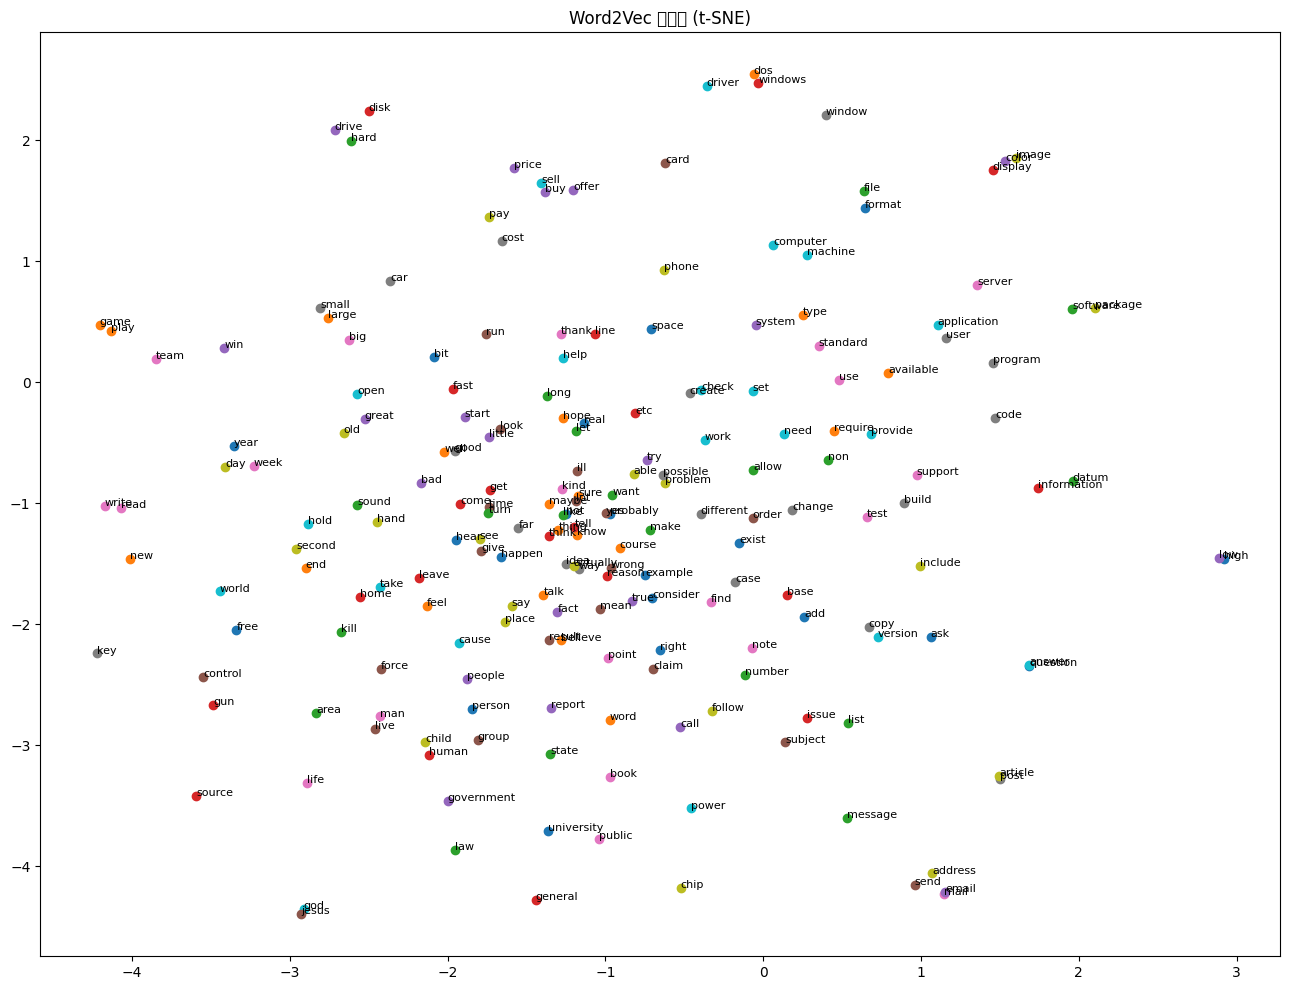

In [ ]:
# 시각화

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# 시각화할 상위 단어 선택
words = w2v_model.wv.index_to_key[:200]
vectors = np.array([w2v_model.wv[word] for word in words])  # ← numpy로 변환

# t-SNE로 2차원 축소
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
reduced = tsne.fit_transform(vectors)

# 시각화
plt.figure(figsize=(16, 12))
for i, word in enumerate(words):
    x, y = reduced[i]
    plt.scatter(x, y)
    plt.annotate(word, (x, y), fontsize=8)
plt.title("Word2Vec 시각화 (t-SNE)")
plt.show()

In [ ]:
# 1. 단어 → 인덱스 사전 만들기
# Word2Vec에서 학습된 단어들 가져오기

vocab = w2v_model.wv.index_to_key  # Word2Vec이 학습한 모든 단어들의 리스트
word2index = {word: idx for idx, word in enumerate(vocab)} #  단어 → 인덱스 매핑 사전

In [ ]:
vocab

['not',
 'know',
 'like',
 'think',
 'people',
 'time',
 'use',
 'good',
 'say',
 'work',
 'year',
 'new',
 'want',
 'come',
 'system',
 'look',
 'find',
 'way',
 'problem',
 'need',
 'right',
 'thing',
 'file',
 'get',
 'try',
 'run',
 'point',
 'program',
 'include',
 'god',
 'question',
 'believe',
 'number',
 'tell',
 'drive',
 'mean',
 'read',
 'post',
 'day',
 'help',
 'bit',
 'game',
 'long',
 'information',
 'start',
 'give',
 'support',
 'case',
 'image',
 'take',
 'ask',
 'well',
 'state',
 'line',
 'government',
 'send',
 'write',
 'key',
 'see',
 'set',
 'high',
 'available',
 'law',
 'etc',
 'call',
 'group',
 'mail',
 'change',
 'follow',
 'power',
 'space',
 'sure',
 'list',
 'base',
 'fact',
 'lot',
 'man',
 'car',
 'place',
 'version',
 'hear',
 'word',
 'software',
 'windows',
 'great',
 'card',
 'book',
 'window',
 'second',
 'world',
 'probably',
 'end',
 'make',
 'reason',
 'little',
 'order',
 'life',
 'different',
 'old',
 'computer',
 'happen',
 'course',
 'let'

In [ ]:
# 2. 사전으로부터 임베딩 행렬 만들기

import numpy as np
import torch

embedding_matrix = np.zeros((len(vocab), w2v_model.vector_size))
for word, idx in word2index.items():
    embedding_matrix[idx] = w2v_model.wv[word]

embedding_matrix = torch.tensor(embedding_matrix, dtype=torch.float32)

평균 길이: 81.8220657597922
최대 길이: 5588
95% 커버 길이: 244.0


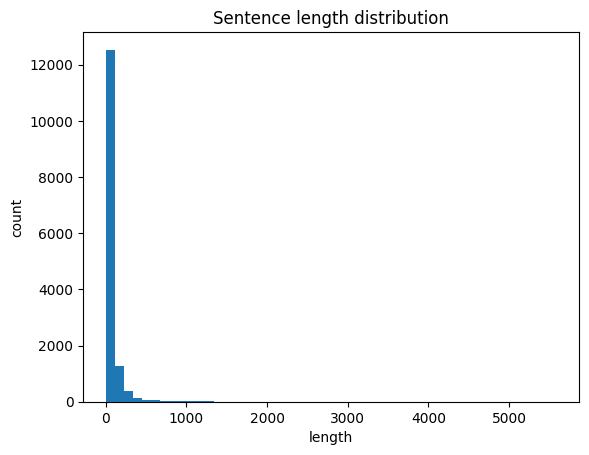

In [ ]:
# 문장 길이 측정
sentence_lengths = [len(tokens) for tokens, _ in train_data]

# 분포 보기
import numpy as np
print("평균 길이:", np.mean(sentence_lengths))
print("최대 길이:", np.max(sentence_lengths))
print("95% 커버 길이:", np.percentile(sentence_lengths, 95))  # 95% 커버하는 최대 길이

# 시각화
import matplotlib.pyplot as plt
plt.hist(sentence_lengths, bins=50)
plt.title("Sentence length distribution")
plt.xlabel("length")
plt.ylabel("count")
plt.show()

- 95% 커버 길이에 맞춰서 max_len 을 244로 설정

In [ ]:
# 3. Dataset 클래스: 토큰을 인덱스로 변환해서 반환

from torch.utils.data import Dataset

class IndexedDataset(Dataset):
    def __init__(self, data, word2index, max_len=244):
        self.data = data
        self.word2index = word2index
        self.max_len = max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):

        # 해당 인덱스의 (토큰, 레이블) 쌍 가져오기
        tokens, label = self.data[idx]

         # 단어를 숫자 인덱스로 변환
        indices = [self.word2index.get(token, 0) for token in tokens]  # 0은 UNK/OOV

        if len(indices) < self.max_len:
            indices += [0] * (self.max_len - len(indices))

        else:
            indices = indices[:self.max_len]
        return torch.tensor(indices), torch.tensor(label, dtype=torch.long)

In [ ]:
# 4. 모델 정의 (LSTM + Embedding)
# index -> 임베딩 벡터로 변환

import torch.nn as nn

class RNNClassifier(nn.Module):
    def __init__(self, embedding_matrix, rnn_type='lstm', hidden_dim=128, num_classes=20, freeze=True):
        super().__init__()
        vocab_size, embedding_dim = embedding_matrix.shape
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix.to(device), freeze=freeze)

        if rnn_type == 'lstm':
            self.rnn = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        elif rnn_type == 'gru':
            self.rnn = nn.GRU(embedding_dim, hidden_dim, batch_first=True)
        else:
            raise ValueError("rnn_type must be 'lstm' or 'gru'")

        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):  # x: [batch_size, seq_len]
        x = self.embedding(x)  # [batch_size, seq_len, emb_dim]
        _, h = self.rnn(x)
        if isinstance(h, tuple):  # LSTM: (hn, cn)
            h = h[0]
        return self.fc(h[-1])  # h: [num_layers, batch, hidden_dim]

In [ ]:
# 5. DataLoader 구성

train_dataset = IndexedDataset(train_data, word2index, max_len=244)
test_dataset = IndexedDataset(test_data, word2index, max_len=244)

from torch.utils.data import DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = RNNClassifier(embedding_matrix, rnn_type='lstm', hidden_dim=128, num_classes=20).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
import torch
import torch.nn.functional as F

def train(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss, correct, total = 0, 0, 0

    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = outputs.argmax(1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    acc = correct / total
    return total_loss / len(dataloader), acc

def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss, correct, total = 0, 0, 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            preds = outputs.argmax(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    acc = correct / total
    return total_loss / len(dataloader), acc

In [ ]:
!pip install wandb

In [ ]:
import wandb
wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: daeseok900 (daeseok900-codeit) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [ ]:
wandb.init(project="mission10", name="Word2Vec", config={
    "embedding": "Word2Vec",
    "rnn_type": "lstm",
    "hidden_dim": 128,
    "batch_size": 32,
    "lr": 1e-3,
    "max_len": 244,
    "epochs": 10
})

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for epoch in range(1, 31):
    train_loss, train_acc = train(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc = evaluate(model, test_loader, criterion, device)

    print(f"Epoch {epoch} | Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")

    wandb.log({
        "epoch": epoch,
        "train_loss": train_loss,
        "train_acc": train_acc,
        "val_loss": val_loss,
        "val_acc": val_acc
    })

Epoch 1 | Train Loss: 2.9880, Acc: 0.0580 | Val Loss: 2.9604, Acc: 0.0651
Epoch 2 | Train Loss: 3.0201, Acc: 0.0533 | Val Loss: 3.0001, Acc: 0.0506
Epoch 3 | Train Loss: 2.9418, Acc: 0.0727 | Val Loss: 2.6783, Acc: 0.1271
Epoch 4 | Train Loss: 2.5821, Acc: 0.1271 | Val Loss: 2.4441, Acc: 0.1566
Epoch 5 | Train Loss: 2.2743, Acc: 0.2210 | Val Loss: 2.2126, Acc: 0.2343
Epoch 6 | Train Loss: 1.9676, Acc: 0.2887 | Val Loss: 1.8798, Acc: 0.3092
Epoch 7 | Train Loss: 1.7839, Acc: 0.3440 | Val Loss: 1.7268, Acc: 0.3773
Epoch 8 | Train Loss: 1.6217, Acc: 0.4065 | Val Loss: 1.5971, Acc: 0.4251
Epoch 9 | Train Loss: 1.4838, Acc: 0.4615 | Val Loss: 1.4370, Acc: 0.5120
Epoch 10 | Train Loss: 1.3303, Acc: 0.5390 | Val Loss: 1.3360, Acc: 0.5566
Epoch 11 | Train Loss: 1.2163, Acc: 0.5951 | Val Loss: 1.2916, Acc: 0.5678
Epoch 12 | Train Loss: 1.1436, Acc: 0.6154 | Val Loss: 1.2366, Acc: 0.6088
Epoch 13 | Train Loss: 1.0809, Acc: 0.6424 | Val Loss: 1.1981, Acc: 0.6107
Epoch 14 | Train Loss: 1.0351, Acc

## FastText

In [ ]:
from gensim.models import FastText

fasttext_model = FastText(
    sentences=train_sentences,
    vector_size=128,
    window=5,
    min_count=2,
    sg=1,
    epochs=10
)

In [ ]:
print(fasttext_model.wv.most_similar("people"))

[('peoples', 0.8465096354484558), ('salespeople', 0.8063775897026062), ('townspeople', 0.8045549988746643), ('spokepeople', 0.7715340256690979), ('peole', 0.7274240255355835), ('spokespeople', 0.7226240634918213), ('hopelessly', 0.7035312056541443), ('persuasion', 0.6753661632537842), ('homeless', 0.6702520847320557), ('pessimist', 0.6702092289924622)]


In [ ]:
# 1. 단어 → 인덱스 사전 만들기
# FastText에서 학습된 단어들 가져오기

vocab_ft = fasttext_model.wv.index_to_key  # Word2Vec이 학습한 모든 단어들의 리스트
fastText_index = {word: idx for idx, word in enumerate(vocab)} #  단어 → 인덱스 매핑 사전

In [ ]:
vocab_ft

['not',
 'know',
 'like',
 'think',
 'people',
 'time',
 'use',
 'good',
 'say',
 'work',
 'year',
 'new',
 'want',
 'come',
 'system',
 'look',
 'find',
 'way',
 'problem',
 'need',
 'right',
 'thing',
 'file',
 'get',
 'try',
 'run',
 'point',
 'program',
 'include',
 'god',
 'question',
 'believe',
 'number',
 'tell',
 'drive',
 'mean',
 'read',
 'post',
 'day',
 'help',
 'bit',
 'game',
 'long',
 'information',
 'start',
 'give',
 'support',
 'case',
 'image',
 'take',
 'ask',
 'well',
 'state',
 'line',
 'government',
 'send',
 'write',
 'key',
 'see',
 'set',
 'high',
 'available',
 'law',
 'etc',
 'call',
 'group',
 'mail',
 'change',
 'follow',
 'power',
 'space',
 'sure',
 'list',
 'base',
 'fact',
 'lot',
 'man',
 'car',
 'place',
 'version',
 'hear',
 'word',
 'software',
 'windows',
 'great',
 'card',
 'book',
 'window',
 'second',
 'world',
 'probably',
 'end',
 'make',
 'reason',
 'little',
 'order',
 'life',
 'different',
 'old',
 'computer',
 'happen',
 'course',
 'let'

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49884 (\N{HANGUL SYLLABLE SI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44033 (\N{HANGUL SYLLABLE GAG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54868 (\N{HANGUL SYLLABLE HWA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


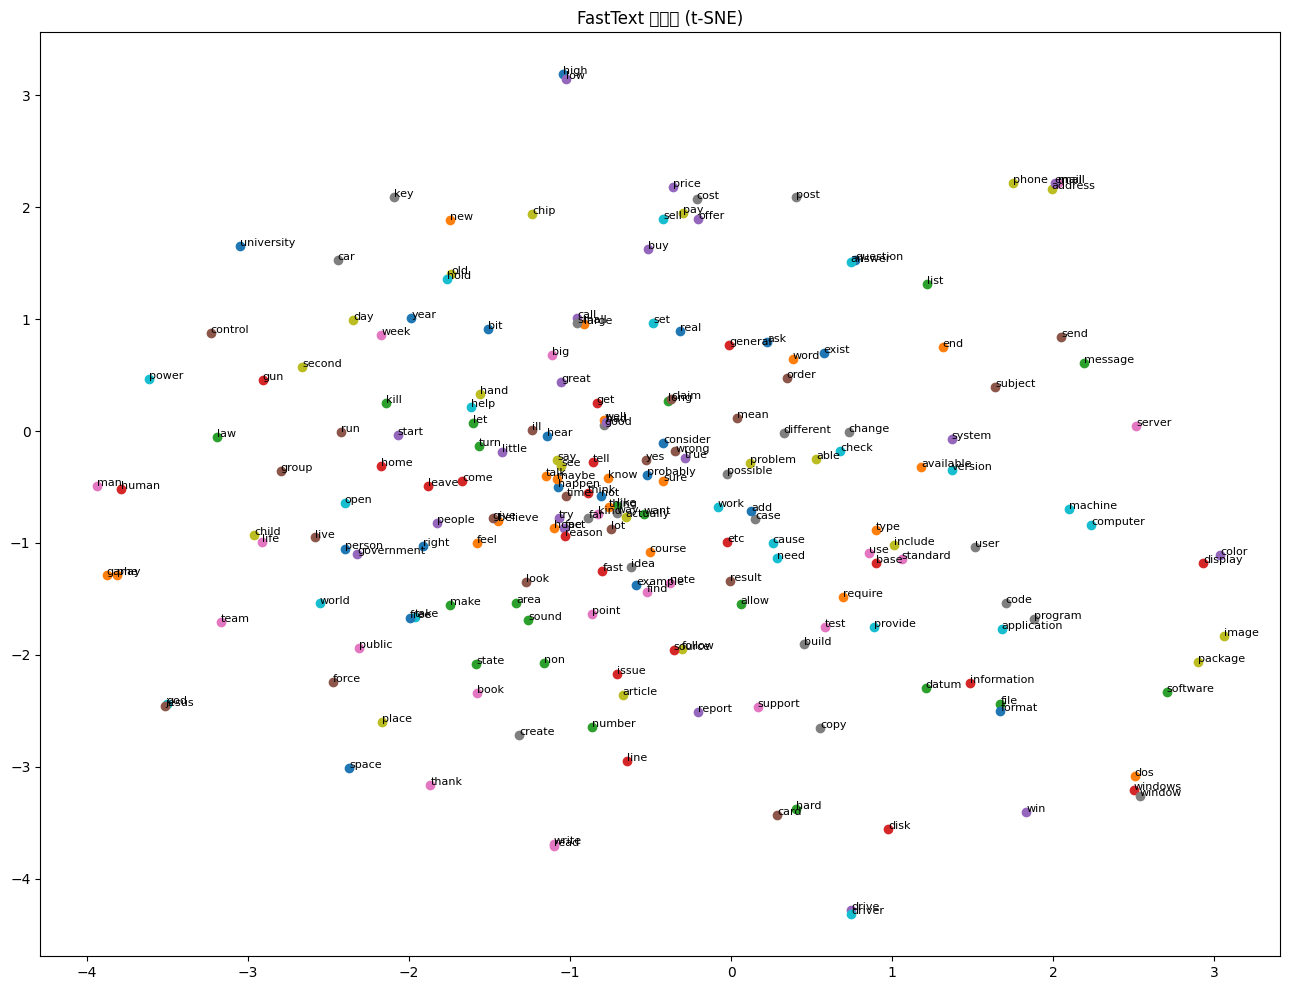

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# 시각화할 상위 단어 선택
words = fasttext_model.wv.index_to_key[:200]
vectors = np.array([fasttext_model.wv[word] for word in words])  # ← numpy로 변환

# t-SNE로 2차원 축소
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
reduced = tsne.fit_transform(vectors)

# 시각화
plt.figure(figsize=(16, 12))
for i, word in enumerate(words):
    x, y = reduced[i]
    plt.scatter(x, y)
    plt.annotate(word, (x, y), fontsize=8)
plt.title("FastText 시각화 (t-SNE)")
plt.show()

In [ ]:
# 사전으로부터 임베딩 행렬 만들기

import numpy as np
import torch

embedding_matrix = np.zeros((len(vocab), fasttext_model.vector_size))
for word, idx in fastText_index.items():
    embedding_matrix[idx] = fasttext_model.wv[word]

embedding_matrix = torch.tensor(embedding_matrix, dtype=torch.float32)

In [ ]:
# Dataset 클래스: 토큰을 인덱스로 변환해서 반환

from torch.utils.data import Dataset

class IndexedDataset(Dataset):
    def __init__(self, data, fastText_index, max_len=244):
        self.data = data  # [(tokens, label), ...]
        self.fastText_index = fastText_index
        self.max_len = max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        tokens, label = self.data[idx]
         # 단어를 숫자 인덱스로 변환
        indices = [self.fastText_index.get(token, 0) for token in tokens]  # 0은 UNK/OOV
        if len(indices) < self.max_len:
            indices += [0] * (self.max_len - len(indices))
        else:
            indices = indices[:self.max_len]
        return torch.tensor(indices), torch.tensor(label, dtype=torch.long)

In [ ]:
# DataLoader 구성

train_dataset = IndexedDataset(train_data, fastText_index, max_len=244)
test_dataset = IndexedDataset(test_data, fastText_index, max_len=244)

from torch.utils.data import DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = RNNClassifier(embedding_matrix, rnn_type='lstm', hidden_dim=128, num_classes=20).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
wandb.init(project="mission10", name="FastText", config={
    "embedding": "FastText",
    "rnn_type": "lstm",
    "hidden_dim": 128,
    "batch_size": 32,
    "lr": 1e-3,
    "max_len": 244,
    "epochs": 10
})

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for epoch in range(1, 31):
    train_loss, train_acc = train(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc = evaluate(model, test_loader, criterion, device)

    print(f"Epoch {epoch} | Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")


    wandb.log({
        "epoch": epoch,
        "train_loss": train_loss,
        "train_acc": train_acc,
        "val_loss": val_loss,
        "val_acc": val_acc
    })

Epoch 1 | Train Loss: 2.9788, Acc: 0.0630 | Val Loss: 2.9529, Acc: 0.0689
Epoch 2 | Train Loss: 2.9466, Acc: 0.0683 | Val Loss: 2.7562, Acc: 0.1099
Epoch 3 | Train Loss: 2.8140, Acc: 0.1082 | Val Loss: 2.7465, Acc: 0.1126
Epoch 4 | Train Loss: 2.7887, Acc: 0.1211 | Val Loss: 2.6210, Acc: 0.1728
Epoch 5 | Train Loss: 2.1717, Acc: 0.2783 | Val Loss: 1.8716, Acc: 0.3688
Epoch 6 | Train Loss: 1.7413, Acc: 0.4098 | Val Loss: 1.5695, Acc: 0.4686
Epoch 7 | Train Loss: 1.4764, Acc: 0.4978 | Val Loss: 1.4041, Acc: 0.5183
Epoch 8 | Train Loss: 1.3084, Acc: 0.5562 | Val Loss: 1.3093, Acc: 0.5547
Epoch 9 | Train Loss: 1.1939, Acc: 0.5922 | Val Loss: 1.2091, Acc: 0.5899
Epoch 10 | Train Loss: 1.1199, Acc: 0.6227 | Val Loss: 1.1866, Acc: 0.6042
Epoch 11 | Train Loss: 1.0629, Acc: 0.6452 | Val Loss: 1.1197, Acc: 0.6340
Epoch 12 | Train Loss: 1.0109, Acc: 0.6660 | Val Loss: 1.1414, Acc: 0.6296
Epoch 13 | Train Loss: 0.9758, Acc: 0.6800 | Val Loss: 1.1037, Acc: 0.6413
Epoch 14 | Train Loss: 0.9320, Acc

## GloVe

In [ ]:
import gensim.downloader as api
glove_model = api.load("glove-wiki-gigaword-100")

glove_model.most_similar("people")

[('others', 0.8318449258804321),
 ('those', 0.8050372004508972),
 ('many', 0.7967616319656372),
 ('some', 0.7750677466392517),
 ('they', 0.7717718482017517),
 ('residents', 0.7647792100906372),
 ('them', 0.7625812888145447),
 ('than', 0.7592476010322571),
 ('all', 0.7585625648498535),
 ('families', 0.7561568021774292)]

In [ ]:
# 단어 → 인덱스 사전 만들기
# Glove에서 학습된 단어들 가져오기

vocab_glove = glove_model.index_to_key  # 전체 단어 리스트
glove_index = {word: idx for idx, word in enumerate(vocab)}

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 45800 (\N{HANGUL SYLLABLE DAN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50612 (\N{HANGUL SYLLABLE EO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51076 (\N{HANGUL SYLLABLE IM}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48288 (\N{HANGUL SYLLABLE BE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 46377 (\N{HANGUL SYLLABLE DING}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/lo

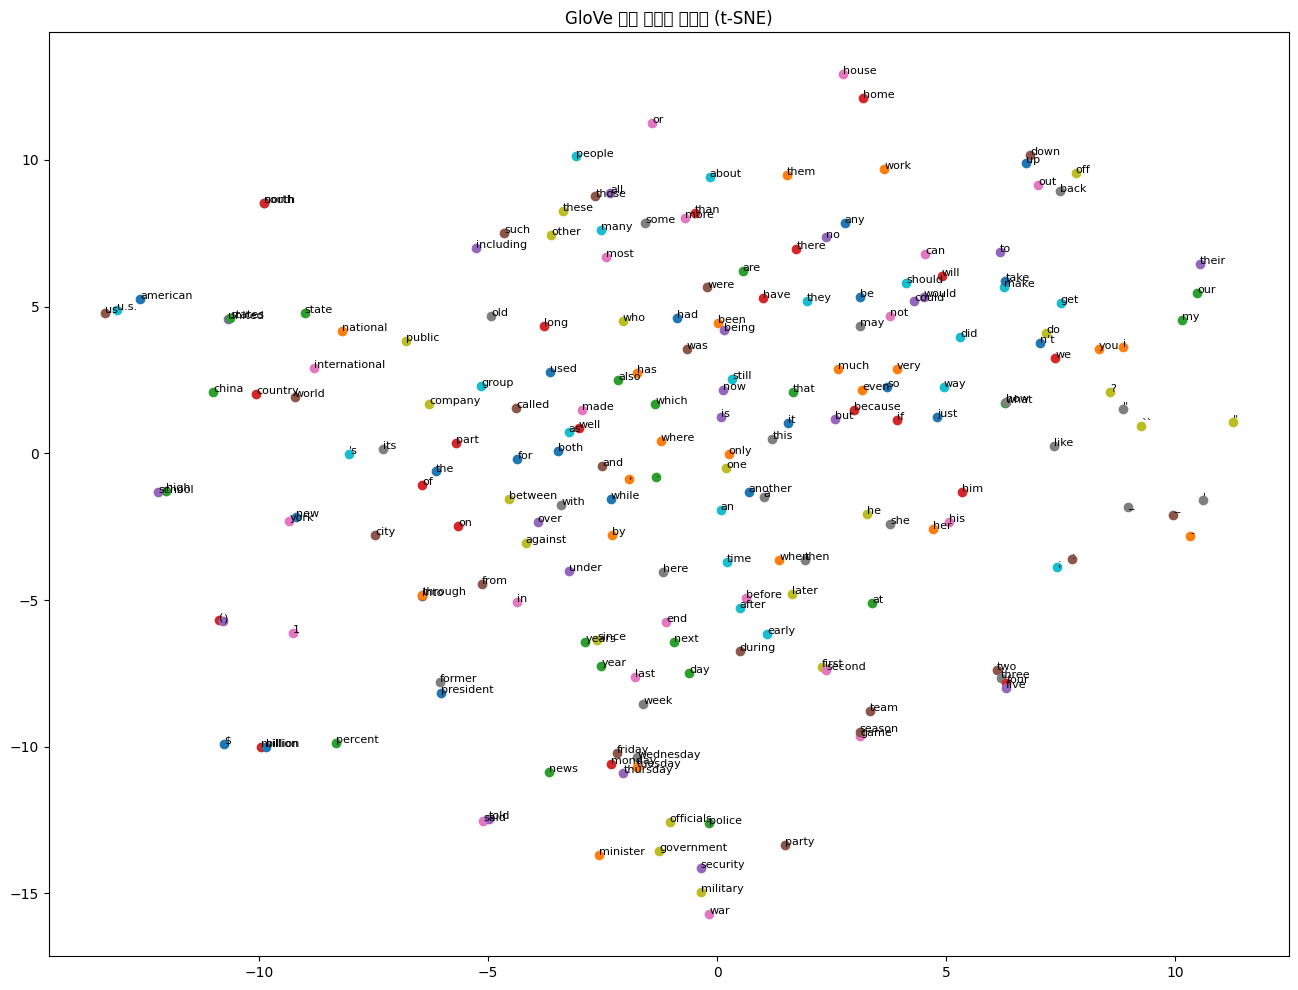

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# 1. GloVe 모델에서 상위 단어 200개 가져오기
words = glove_model.index_to_key[:200]

# 2. 각 단어의 벡터 가져오기
vectors = np.array([glove_model[word] for word in words])

# 3. t-SNE로 차원 축소
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
reduced = tsne.fit_transform(vectors)

# 4. 시각화
plt.figure(figsize=(16, 12))
for i, word in enumerate(words):
    x, y = reduced[i]
    plt.scatter(x, y)
    plt.annotate(word, (x, y), fontsize=8)
plt.title("GloVe 단어 임베딩 시각화 (t-SNE)")
plt.show()

In [ ]:
import numpy as np
import torch

vocab = glove_model.index_to_key
glove_index = {word: idx for idx, word in enumerate(vocab)}
UNK_TOKEN = "<UNK>"

if UNK_TOKEN not in glove_index:
    glove_index[UNK_TOKEN] = len(glove_index)
    glove_model.add_vector(UNK_TOKEN, np.random.normal(scale=0.6, size=(glove_model.vector_size,)))

embedding_matrix = np.zeros((len(glove_index), glove_model.vector_size))
for word, idx in glove_index.items():
    embedding_matrix[idx] = glove_model[word]

embedding_matrix = torch.tensor(embedding_matrix, dtype=torch.float32)

/usr/local/lib/python3.11/dist-packages/gensim/models/keyedvectors.py:551: UserWarning: Adding single vectors to a KeyedVectors which grows by one each time can be costly. Consider adding in batches or preallocating to the required size.
  warnings.warn(


In [ ]:
from torch.utils.data import Dataset

class IndexedDataset(Dataset):
    def __init__(self, data, glove_index, max_len=244):
        self.data = data  # [(tokens, label), ...]
        self.glove_index = glove_index
        self.max_len = max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        tokens, label = self.data[idx]
        indices = [self.glove_index.get(token, self.glove_index["<UNK>"]) for token in tokens]
        if len(indices) < self.max_len:
            indices += [0] * (self.max_len - len(indices))
        else:
            indices = indices[:self.max_len]
        return torch.tensor(indices), torch.tensor(label, dtype=torch.long)

In [ ]:
train_dataset = IndexedDataset(train_data, glove_index, max_len=244)
test_dataset = IndexedDataset(test_data, glove_index, max_len=244)

from torch.utils.data import DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

In [ ]:
wandb.init(project="mission10", name="GloVe", config={
    "embedding": "GloVe",
    "rnn_type": "lstm",
    "hidden_dim": 128,
    "batch_size": 32,
    "lr": 1e-3,
    "max_len": 244,
    "epochs": 10
})

epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
train_acc,▁▁▁▂▃▄▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇███████
train_loss,███▇▆▅▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
val_acc,▁▁▂▂▄▆▆▇▇▇▇▇██████████████████
val_loss,█▇▇▇▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂
epoch,30
train_acc,0.86575
train_loss,0.42245
val_acc,0.67879
val_loss,1.28199


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = RNNClassifier(embedding_matrix, rnn_type='lstm', hidden_dim=128, num_classes=20).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for epoch in range(1, 31):
    train_loss, train_acc = train(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc = evaluate(model, test_loader, criterion, device)

    print(f"Epoch {epoch} | Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")

    wandb.log({
        "epoch": epoch,
        "train_loss": train_loss,
        "train_acc": train_acc,
        "val_loss": val_loss,
        "val_acc": val_acc
    })

Epoch 1 | Train Loss: 2.9816, Acc: 0.0599 | Val Loss: 2.9573, Acc: 0.0522
Epoch 2 | Train Loss: 2.8786, Acc: 0.0789 | Val Loss: 2.9825, Acc: 0.0462
Epoch 3 | Train Loss: 2.9063, Acc: 0.0749 | Val Loss: 2.6823, Acc: 0.1074
Epoch 4 | Train Loss: 2.6027, Acc: 0.1426 | Val Loss: 2.3046, Acc: 0.2534
Epoch 5 | Train Loss: 2.1150, Acc: 0.2840 | Val Loss: 1.9606, Acc: 0.3264
Epoch 6 | Train Loss: 1.9732, Acc: 0.3364 | Val Loss: 1.8272, Acc: 0.3715
Epoch 7 | Train Loss: 1.7173, Acc: 0.4089 | Val Loss: 1.6667, Acc: 0.4347
Epoch 8 | Train Loss: 1.5511, Acc: 0.4655 | Val Loss: 1.5231, Acc: 0.4893
Epoch 9 | Train Loss: 1.4223, Acc: 0.5135 | Val Loss: 1.4495, Acc: 0.5082
Epoch 10 | Train Loss: 1.3388, Acc: 0.5434 | Val Loss: 1.4270, Acc: 0.5208
Epoch 11 | Train Loss: 1.2507, Acc: 0.5753 | Val Loss: 1.3667, Acc: 0.5528
Epoch 12 | Train Loss: 1.1840, Acc: 0.6040 | Val Loss: 1.3042, Acc: 0.5768
Epoch 13 | Train Loss: 1.1128, Acc: 0.6311 | Val Loss: 1.2898, Acc: 0.5812
Epoch 14 | Train Loss: 1.0552, Acc

## Word2vec/FastText/Glove 성능 비교

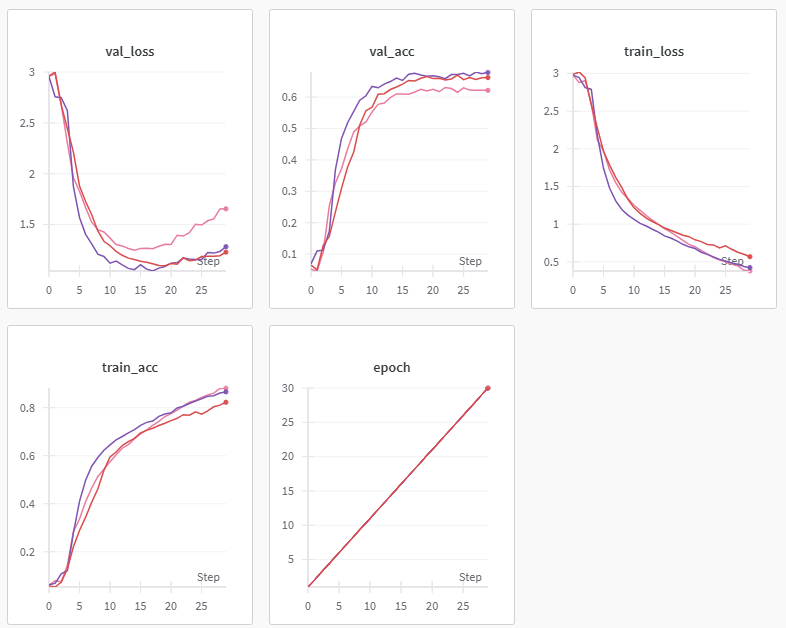

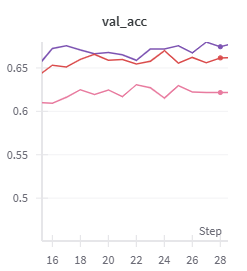

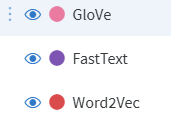

- Validation Accuracy
 - FastText가 가장 빠르게 상승하며 최종 정확도도 가장 높음 :
FastText : Epoch 30 | Train Loss: 0.4224, Acc: 0.8657 | Val Loss: 1.2820, Acc: 0.6788
 - FastText > Word2Vec > GloVe (val_acc 기준)

- Validation Loss
 - FastText가 가장 안정적으로 낮은 손실을 유지

- 17~18 epdoch 부터 과적합 조짐이 있음

# 모델 성능 개선
- 개선할 임베딩 방법 : FastText
- window 5 -> 10
- epochs 10 -> 30

In [ ]:
from gensim.models import FastText

fasttext_model = FastText(
    sentences=train_sentences,
    vector_size=128,
    window=10,
    min_count=2,
    sg=1,
    epochs=30
)

In [ ]:
# 1. 단어 → 인덱스 사전 만들기
# FastText 학습된 단어들 가져오기

vocab_ft = fasttext_model.wv.index_to_key  # Word2Vec이 학습한 모든 단어들의 리스트
fastText_index = {word: idx for idx, word in enumerate(vocab)} #  단어 → 인덱스 매핑 사전

In [ ]:
# 사전으로부터 임베딩 행렬 만들기

import numpy as np
import torch

embedding_matrix = np.zeros((len(vocab), fasttext_model.vector_size))
for word, idx in fastText_index.items():
    embedding_matrix[idx] = fasttext_model.wv[word]

embedding_matrix = torch.tensor(embedding_matrix, dtype=torch.float32)

In [ ]:
# Dataset 클래스: 토큰을 인덱스로 변환해서 반환

from torch.utils.data import Dataset

class IndexedDataset(Dataset):
    def __init__(self, data, fastText_index, max_len=244):
        self.data = data  # [(tokens, label), ...]
        self.fastText_index = fastText_index
        self.max_len = max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        tokens, label = self.data[idx]
         # 단어를 숫자 인덱스로 변환
        indices = [self.fastText_index.get(token, 0) for token in tokens]  # 0은 UNK/OOV
        if len(indices) < self.max_len:
            indices += [0] * (self.max_len - len(indices))
        else:
            indices = indices[:self.max_len]
        return torch.tensor(indices), torch.tensor(label, dtype=torch.long)

In [ ]:
# DataLoader 구성

train_dataset = IndexedDataset(train_data, fastText_index, max_len=244)
test_dataset = IndexedDataset(test_data, fastText_index, max_len=244)

from torch.utils.data import DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = RNNClassifier(embedding_matrix, rnn_type='lstm', hidden_dim=128, num_classes=20).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for epoch in range(1, 31):
    train_loss, train_acc = train(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc = evaluate(model, test_loader, criterion, device)

    print(f"Epoch {epoch} | Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")

Epoch 1 | Train Loss: 2.9828, Acc: 0.0581 | Val Loss: 2.9594, Acc: 0.0631
Epoch 2 | Train Loss: 2.8874, Acc: 0.0770 | Val Loss: 2.6056, Acc: 0.1088
Epoch 3 | Train Loss: 2.5916, Acc: 0.1209 | Val Loss: 2.6856, Acc: 0.1465
Epoch 4 | Train Loss: 2.3810, Acc: 0.1847 | Val Loss: 2.2312, Acc: 0.2179
Epoch 5 | Train Loss: 2.2152, Acc: 0.2301 | Val Loss: 2.2677, Acc: 0.2089
Epoch 6 | Train Loss: 1.9590, Acc: 0.2997 | Val Loss: 1.7987, Acc: 0.3647
Epoch 7 | Train Loss: 1.6175, Acc: 0.4337 | Val Loss: 1.5206, Acc: 0.4770
Epoch 8 | Train Loss: 1.3755, Acc: 0.5308 | Val Loss: 1.3237, Acc: 0.5593
Epoch 9 | Train Loss: 1.2097, Acc: 0.5984 | Val Loss: 1.2332, Acc: 0.5858
Epoch 10 | Train Loss: 1.0901, Acc: 0.6417 | Val Loss: 1.1106, Acc: 0.6391
Epoch 11 | Train Loss: 1.0169, Acc: 0.6733 | Val Loss: 1.0959, Acc: 0.6501
Epoch 12 | Train Loss: 0.9607, Acc: 0.6932 | Val Loss: 1.0522, Acc: 0.6602
Epoch 13 | Train Loss: 0.9011, Acc: 0.7146 | Val Loss: 1.0236, Acc: 0.6744
Epoch 14 | Train Loss: 0.8623, Acc

Val Loss: 1.2820, Acc: 0.6788 -> Val Loss: 1.0903, Acc: 0.7050
- 성능 향상

FastText 임베딩에서 window size를 5에서 10으로, 학습 epoch을 10에서 30으로 늘렸을 때, validation accuracy가 약 5% 가량 향상되었으며, 전반적인 loss도 감소하는 추세를 보였다.
이는 **더 넓은 문맥 정보(window)**와 **충분한 학습 반복(epoch)**이 단어 임베딩 품질 향상에 기여했음을 의미한다.